# Compare models for visual proprioception

Compares regression models for visual proprioception, by running them on specific test data, and creating comparison graphs that put all of them onto the graphs. 

Each configuration is specified by a run of type visual_proprioception.

In [2]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"


import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import math
import torch
import torch.nn as nn
import csv
#import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

#from sensorprocessing import sp_conv_vae, sp_propriotuned_cnn, sp_vit

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training, load_multiview_demonstrations_as_proprioception_training
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression
import sensorprocessing.sp_factory as sp_factory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
#
# Code for deterministic run, from Robi Konievic
#
superpower=777
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
torch.use_deterministic_algorithms(True)
torch.manual_seed(superpower)
import random
random.seed(superpower)
import numpy as np
np.random.seed(superpower)
torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(superpower)

In [10]:

# If it is set to discard-old, the exprun will be recreated from scratch
creation_style = "exist-ok"

experiment = "visual_proprioception"
# run = "vp_comp_flow_all"
run = "vit_base"

# If not None, set the epochs to something different than the exp
epochs = None

# If not None, set an external experiment path
external_path = None
#external_path = r"C:\Users\lotzi\Work\_DataExternal\VisualProprioception_flow_00\exprun"
# external_path = r"C:\Users\lotzi\Work\_Data\BerryPicker-Flows\cvpr_simulation_000\exprun"

# If not None, set an output path
data_path = None
#data_path = r"C:\Users\lotzi\Work\_DataExternal\VisualProprioception_flow_00\result"
# data_path = r"C:\Users\lotzi\Work\_Data\BerryPicker-Flows\cvpr_simulation_000\result"


In [13]:
if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_exprun_path(external_path)
    Config().copy_experiment("sensorprocessing_aruco")
    Config().copy_experiment("sensorprocessing_conv_vae")
    Config().copy_experiment("sensorprocessing_propriotuned_Vit")
    Config().copy_experiment("sensorprocessing_propriotuned_cnn")
    Config().copy_experiment("robot_al5d")
    Config().copy_experiment("demonstration")
if data_path:
    data_path = pathlib.Path(data_path)
    assert data_path.exists()
    Config().set_results_path(data_path)

exp = Config().get_experiment(experiment, run)
# runs = exp["tocompare"]
# run = "vp_ptun_vgg19_128"
runs = ["vit_base"]
# runs = ["vp_convvae_128", "vp_convvae_256", "vp_ptun_vgg19_128", "vp_ptun_vgg19_256", "vp_ptun_resnet50_128", "vp_ptun_resnet50_256", "vp_aruco_128"]


exp_robot = Config().get_experiment(exp["robot_exp"], exp["robot_run"])
subexps = [] # the sub experiments that we are comparing
sps = [ ]
spexps = [ ]
models = [ ]
# FIXME: it is not a good idea to hardwire this, later we should refer
# from the comparison exprun
exp_robot = Config().get_experiment("robot_al5d", "position_controller_00")
firstexp = None # the first experiment, this is where we get the data from
for subrun in runs:
    subexp = Config().get_experiment(experiment, subrun)
    if firstexp is None:
        firstexp = subexp
    subexps.append(subexp)
    spexp = Config().get_experiment(subexp["sp_experiment"], subexp["sp_run"])
    spexps.append(spexp)
    sp = sp_factory.create_sp(spexp, device)
    sps.append(sp)
    model = VisProprio_SimpleMLPRegression(subexp)
    modelfile = pathlib.Path(subexp["data_dir"],
                            subexp["proprioception_mlp_model_file"])
    model.load_state_dict(torch.load(modelfile))
    model.to(device)
    models.append(model)


***ExpRun**: Configuration for exp/run: visual_proprioception/vp_ptun_vgg19_128 successfully loaded
***ExpRun**: Configuration for exp/run: robot_al5d/position_controller_00 successfully loaded
***ExpRun**: Configuration for exp/run: robot_al5d/position_controller_00 successfully loaded
***ExpRun**: Configuration for exp/run: visual_proprioception/vp_convvae_128 successfully loaded
***ExpRun**: Configuration for exp/run: sensorprocessing_conv_vae/sp_vae_128 successfully loaded


FileNotFoundError: [Errno 2] No such file or directory: '/home/sa641631/WORK/BerryPicker/data/sensorprocessing_conv_vae/sp_vae_128/config.json'

In [5]:
# Load test data for the lead experiment
# task = leadexp["proprioception_testing_task"]
proprioception_input_file = pathlib.Path(
    firstexp.data_dir(), firstexp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(
    firstexp.data_dir(), firstexp["proprioception_test_target_file"])

# Check if lead experiment is multi-view
is_lead_multiview = exp.get("sensor_processing", "") == "Vit_multiview" or firstexp.get("num_views", 1) > 1

if is_lead_multiview:
    # Use multi-view loading function for the lead experiment
    tr = load_multiview_demonstrations_as_proprioception_training(
        task,
        proprioception_input_file,
        proprioception_target_file,
        num_views=firstexp.get("num_views", 2)
    )
else:
    # Use original single-view loading function
    # These are actually just using the last ones
    tr = load_demonstrations_as_proprioception_training(
        sps[0], firstexp, spexps[0], exp_robot, "validation_data", proprioception_input_file, proprioception_target_file, device=device
    )


# The targets should be the same regardless of single or multi-view
targets = tr["targets"]
print(f"There are {targets.shape[0]} target data points")

***load_demonstrations_as_proprioception_training*** 
	Successfully loaded from cached files C:\Users\lotzi\Work\_Data\BerryPicker-Flows\cvpr_simulation_000\result\visual_proprioception\vp_vgg19_128_0001\test_inputs.pt etc
There are 1103 target data points


Iterate through all the components. The thing with it though is that this will get the test data from the components, not from the lead exp.

FIXME: maybe I could just write a function that runs a particular proprioceptor on a whole task and returns the y, and then just call that. 

In [6]:
no_from = 0
no_to = targets.shape[0]-1

ypreds = []

for subexp, sp, spexp, model in zip(subexps, sps, spexps, models):
    # Make sure both sp and model are on the same device
    model = model.to(device)
    proprioception_input_file = pathlib.Path(
        subexp.data_dir(), subexp["proprioception_test_input_file"])
    proprioception_target_file = pathlib.Path(
        subexp.data_dir(), subexp["proprioception_test_target_file"])

    # Check if this is a multi-view model
    is_multiview = subexp.get("sensor_processing", "") == "Vit_multiview" or subexp.get("num_views", 1) > 1

    if is_multiview:
        # Use the multi-view data loading function
        tr = load_multiview_demonstrations_as_proprioception_training(
            task,
            proprioception_input_file,
            proprioception_target_file,
            num_views=subexp.get("num_views", 2)
        )

        # Process each data point
        ypred = []
        y = []
        t = []

        with torch.no_grad():
            for i in range(no_from, no_to):
                # Get the latent representation from sp (which handles the multi-view encoding)
                views = [view[i].unsqueeze(0).to(device) for view in tr["view_inputs"]]
                latent = sp.process(views)

                # Important: Make sure the latent tensor is on the same device as the model
                latent_tensor = torch.from_numpy(latent).unsqueeze(0).to(device)
                # Pass latent to regression model
                predictions = model(latent_tensor)
                # Append the data
                t.append(i)
                y.append(targets[i].numpy())
                ypred.append(predictions[0].cpu().numpy())
    else:
        # Original single-view approach
        tr = load_demonstrations_as_proprioception_training(
            sp, subexp, spexp, exp_robot, "validation_data", proprioception_input_file, proprioception_target_file, device=device
        )
        inputs = tr["inputs"]
        ypred = []
        y = []
        t = []
        with torch.no_grad():
            for i in range(no_from, no_to):
                # Move input to the correct device
                x = inputs[i].to(device)
                predictions = model(torch.unsqueeze(x, dim=0))

                # Move predictions back to CPU for numpy conversion
                # Append the data
                t.append(i)
                y.append(targets[i].numpy())
                ypred.append(predictions[0].cpu().numpy())

    ypred = np.array(ypred)
    ypreds.append(ypred)
    y = np.array(y)
    t = np.array(t)

***load_demonstrations_as_proprioception_training*** 
	Successfully loaded from cached files C:\Users\lotzi\Work\_Data\BerryPicker-Flows\cvpr_simulation_000\result\visual_proprioception\vp_vgg19_128_0001\test_inputs.pt etc
***load_demonstrations_as_proprioception_training*** 
	Successfully loaded from cached files C:\Users\lotzi\Work\_Data\BerryPicker-Flows\cvpr_simulation_000\result\visual_proprioception\vp_vgg19_256_0001\test_inputs.pt etc


## Time compare plot - double column
At this point, we should have the ypreds, the y and the t and we can plot them.

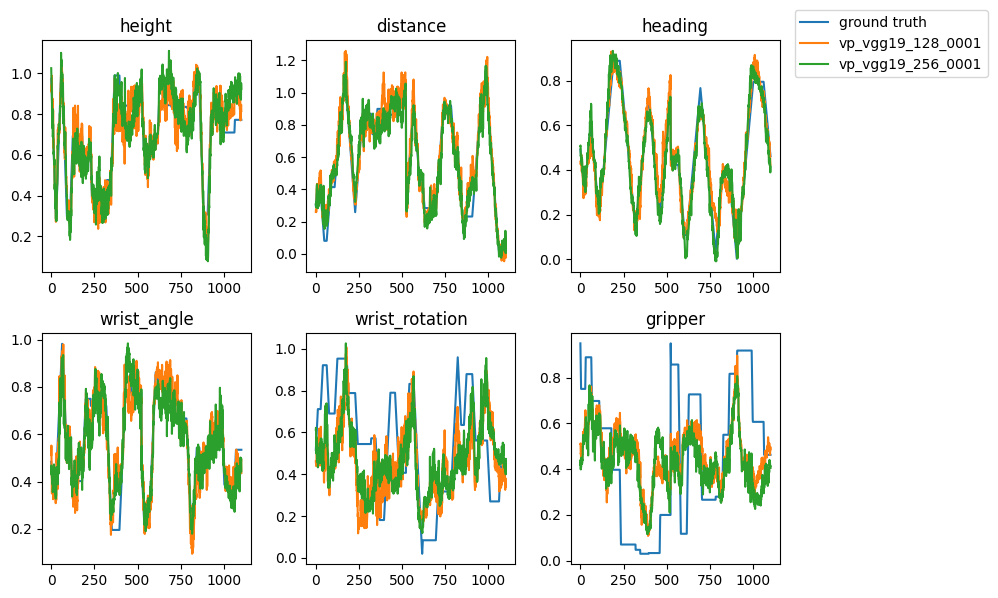

In [7]:
fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(len(titles)):
    ax = axs[i//3, i%3]
    # ax.set_ylim(0, 1.4)
    ax.plot(t, y[:,i], label="ground truth")
    for ypred, subexp in zip(ypreds,subexps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=subexp["name"])
    if i==0:
        fig.legend(bbox_to_anchor=(1.25, 1))
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp["data_dir"], "comparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

## Time compare plot, single column

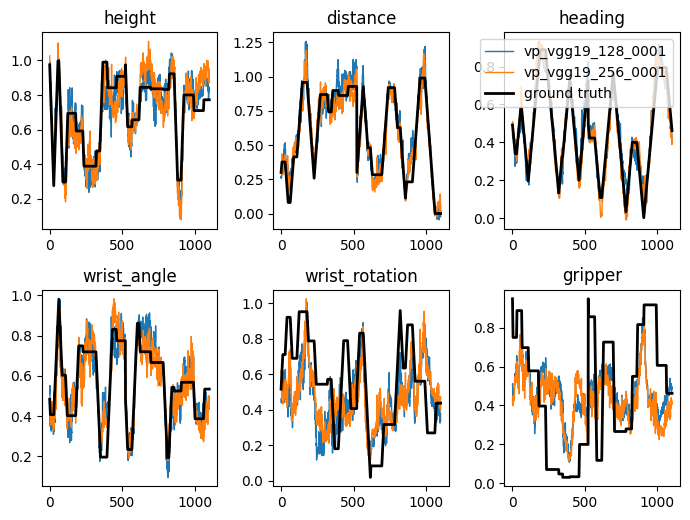

In [8]:
fig, axs = plt.subplots(2,3, figsize=(7, 5.3))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(len(titles)):
    ax = axs[i//3, i%3]
    # ax.set_ylim(0, 2.0)
    for ypred, subexp in zip(ypreds,subexps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=subexp["name"], linewidth=1)
    ax.plot(t, y[:,i], label="ground truth", linewidth=2, color="black")
    if i==2:
        ax.legend()
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp["data_dir"], "comparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

## Time compare plot, vertical with legend bottom

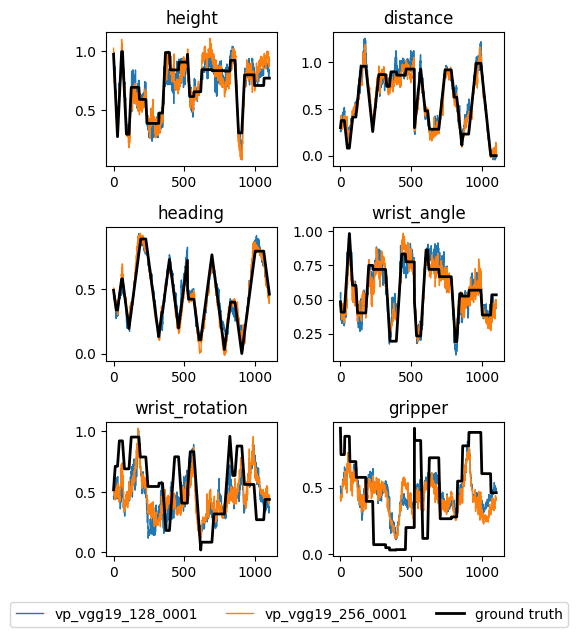

In [9]:
#fig, axs = plt.subplots(3,2, figsize=(5.3, 7))
fig, axs = plt.subplots(3,2, figsize=(4.6, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(len(titles)):
    ax = axs[i//2, i%2]
    #ax.set_ylim(0, 2.0)
    for ypred, subexp in zip(ypreds,subexps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=subexp["name"], linewidth=1)
    ax.plot(t, y[:,i], label="ground truth", linewidth=2, color="black")
    if i==4:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=len(subexps)+1,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp["data_dir"], "comparison23.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(exp["data_dir"], "comparison23.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

### Comparing the average accuracy
Create a graph that is comparing the average accuracy. 

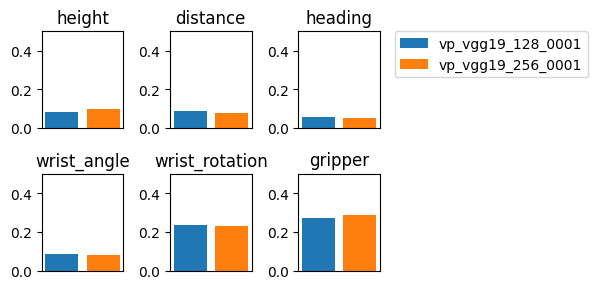

In [10]:
fig, axs = plt.subplots(2,3, figsize=(4, 3))

for i in range(len(titles)):
    ax = axs[i//3, i%3]
    # ax.set_ylim(0, 0.4)
    ax.set_ylim(0, 0.5)
    # ax.plot(t, y[:,i], label="y")
    bars = []
    names = []
    for ypred, subexp in zip(ypreds,subexps):
        ## FIXME: some kind of different plot
        # error = avg(y[:,i], ypred[:,i])
        error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
        br = ax.bar(subexp["name"], error)
        bars.append(br)
        names.append(subexp["name"])
    # Remove x-axis labels if desired
    ax.set_xticks([])
    if i==0:
        fig.legend(bars, names, bbox_to_anchor=(1.50, 0.9), ncol=1)
    fig.tight_layout()
    ax.set_title(titles[i])

fig.tight_layout()
graphfilename = pathlib.Path(exp["data_dir"], "msecomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(exp["data_dir"], "msecomparison.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

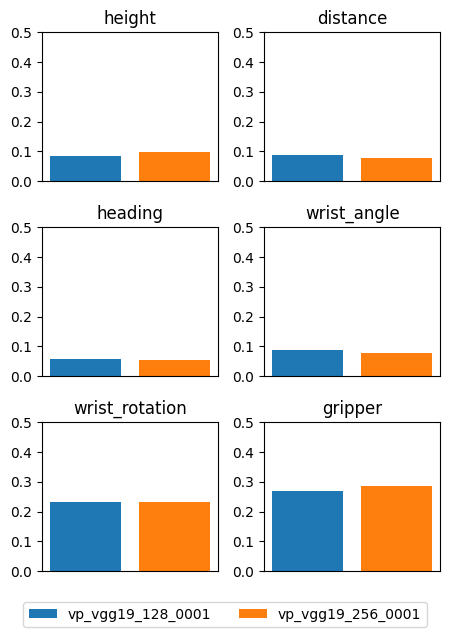

In [11]:
fig, axs = plt.subplots(3,2, figsize=(4.6, 6))

for i in range(len(titles)):
    ax = axs[i//2, i%2]
    # ax.set_ylim(0, 0.4)
    ax.set_ylim(0, 0.5)
    # ax.plot(t, y[:,i], label="y")
    bars = []
    names = []
    for ypred, subexp in zip(ypreds,subexps):
        ## FIXME: some kind of different plot
        # error = avg(y[:,i], ypred[:,i])
        error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
        br = ax.bar(subexp["name"], error, label=subexp["name"])
        bars.append(br)
        names.append(subexp["name"])
    # Remove x-axis labels if desired
    ax.set_xticks([])
    if i==4:
        handles, labels = ax.get_legend_handles_labels()
        #ncolumn = len(exps)
        ncolumn = 2
        fig.legend(handles, labels, ncol=ncolumn,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    # fig.tight_layout()
    ax.set_title(titles[i])

fig.tight_layout()
graphfilename = pathlib.Path(exp["data_dir"], "msecomparison23.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(exp["data_dir"], "msecomparison23.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

## Generate csv file for further processing

Code by Robert-Anton Konievic

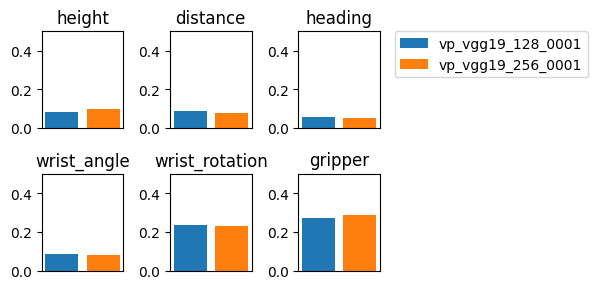

In [12]:
fig, axs = plt.subplots(2,3, figsize=(4, 3))

for i in range(len(titles)):
    ax = axs[i//3, i%3]
    # ax.set_ylim(0, 0.4)
    ax.set_ylim(0, 0.5)
    # ax.plot(t, y[:,i], label="y")
    bars = []
    names = []
    with open(pathlib.Path(exp["data_dir"], "msecomparison_values.txt"),'a') as mse_values_file:
        mse_values_file.write(titles[i] + ": " + '\n')
    for ypred, subexp in zip(ypreds,subexps):
        ## FIXME: some kind of different plot
        # error = avg(y[:,i], ypred[:,i])
        error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
        br = ax.bar(subexp["name"], error)
        bars.append(br)
        names.append(subexp["name"])
        with open(pathlib.Path(exp["data_dir"],
            "msecomparison_values.txt"),'a') as mse_values_file:
            mse_values_file.write(subexp["name"] + ": " + str(error) + '\n')
    # csv_path = pathlib.Path(exp["data_dir"], "all_msecomparison_values.csv")
    csv_path = pathlib.Path(exp["data_dir"], "all_msecomparison_values.csv")


# If you’re running this in a loop for multiple titles, open once per run
# Use 'a' to append to the existing file, or 'w' to overwrite.
    with open(csv_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header row only if file is new/empty
        if csv_path.stat().st_size == 0:
            writer.writerow(["Title"] + [subexp["name"] for subexp in subexps])
         # Compute all errors for the current title
        errors = []
        for ypred, subexp in zip(ypreds, subexps):
            error = math.sqrt(np.mean((y[:, i] - ypred[:, i]) ** 2))
            errors.append(error)
         # Write one row per title (e.g. per experiment)
        writer.writerow([titles[i]] + errors)

     # Remove x-axis labels if desired
    ax.set_xticks([])
    if i==0:
        fig.legend(bars, names, bbox_to_anchor=(1.50, 0.9), ncol=1)
    fig.tight_layout()
    ax.set_title(titles[i])

fig.tight_layout()
graphfilename = pathlib.Path(exp["data_dir"], "msecomparison-robi.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(exp["data_dir"], "msecomparison-robi.jpg")
plt.savefig(graphfilename, bbox_inches='tight')